In [112]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from skimage.feature import graycoprops, graycomatrix, local_binary_pattern
import os
from PIL import Image
import random
import glob

In [113]:
dataset_path = "dataset_breast_cancer_augmented/"

class_names = os.listdir(dataset_path)
print(class_names)

['ganas', 'jinak', 'normal']


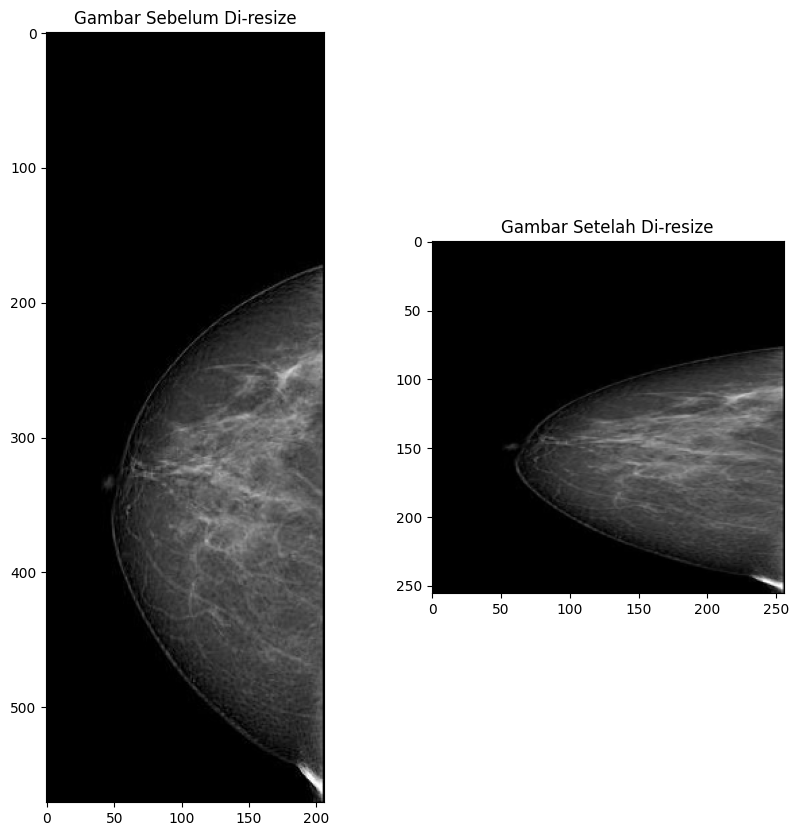

In [114]:
IMAGE_SIZE = (256, 256)

image_path = dataset_path + "ganas/*.jpg"
images = glob.glob(image_path)
random_image_path = random.choice(images)

random_image = Image.open(random_image_path)

random_image_resize = random_image.resize(IMAGE_SIZE)

plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.title('Gambar Sebelum Di-resize')
plt.imshow(random_image)

plt.subplot(1, 2, 2)
plt.title('Gambar Setelah Di-resize')
plt.imshow(random_image_resize)

In [115]:
glcm_distances = [1, 2, 3, 4]  # Different distances to capture varying texture scales

# Updated GLCM angles
glcm_angles = [0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi, 5*np.pi/4, 3*np.pi/2]  # Additional angles

# Updated GLCM properties
glcm_properties = ['contrast', 'homogeneity', 'energy', 'correlation', 'dissimilarity', 'ASM']  # Additional properties

In [116]:
hsv_properties = ['hue', 'saturation', 'value']

In [117]:
features = []
labels = []

# Feature extraction function for color histograms
def extract_color_histogram(image, bins=(8, 8, 8)):
    hist = cv2.calcHist([image], [0, 1, 2], None, bins, [0, 180, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist

# Feature extraction function for LBP
def extract_lbp_features(image, num_points=24, radius=3):
    lbp = local_binary_pattern(image, num_points, radius, method="uniform")
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, num_points + 3), range=(0, num_points + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)  # Normalize the histogram
    return hist

# Loop through the dataset
for folder_name in class_names:
    folder_path = os.path.join(dataset_path, folder_name)
    for file_name in os.listdir(folder_path):
        image_path = os.path.join(folder_path, file_name)
        image = cv2.imread(image_path)
        image = cv2.resize(image, IMAGE_SIZE)

        # Convert the image to HSV and grayscale
        hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # --- Extract HSV Features (mean and std) ---
        hsv_features = []
        for property_name in hsv_properties:
            property_value = hsv_image[:, :, hsv_properties.index(property_name)].ravel()
            hsv_features.extend([np.mean(property_value), np.std(property_value)])

        # --- Extract GLCM Features ---
        glcm = graycomatrix(gray_image, distances=glcm_distances, angles=glcm_angles, symmetric=True, normed=True)
        glcm_features = []
        for property_name in glcm_properties:
            property_value = graycoprops(glcm, property_name).ravel()
            glcm_features.extend([np.mean(property_value), np.std(property_value)])

        # --- Extract Color Histogram Features ---
        color_histogram_features = extract_color_histogram(hsv_image)

        # --- Extract LBP Features ---
        lbp_features = extract_lbp_features(gray_image)

        # --- Extract Sobel Edge Features ---
        sobelx = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize=3)
        sobelx_mean, sobelx_std = np.mean(sobelx), np.std(sobelx)
        sobely_mean, sobely_std = np.mean(sobely), np.std(sobely)
        sobel_features = [sobelx_mean, sobelx_std, sobely_mean, sobely_std]

        # Combine all features
        combined_features = np.concatenate([hsv_features, glcm_features, color_histogram_features, lbp_features, sobel_features])

        # Append to features and labels list
        features.append(combined_features)
        labels.append(class_names.index(folder_name))

# Convert features and labels to numpy arrays
features = np.array(features)
labels = np.array(labels)

In [118]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
features = scaler.fit_transform(features)

In [127]:
import pickle
with open('scaler.pkl', 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)

In [119]:
import numpy as np

# Convert features and labels to numpy arrays for easier manipulation
features = np.array(features)
labels = np.array(labels)

# Shuffle the indices
indices = np.arange(features.shape[0])
np.random.seed(42)  # Set seed for reproducibility
np.random.shuffle(indices)

# Define the split ratio
split_ratio = 0.8
split_index = int(len(indices) * split_ratio)

# Split the indices for training and testing
train_indices = indices[:split_index]
test_indices = indices[split_index:]

# Create training and testing sets using the indices
X_train, X_test = features[train_indices], features[test_indices]
y_train, y_test = labels[train_indices], labels[test_indices]

# Verify the sizes of the splits
print("Training set size:", X_train.shape[0])
print("Testing set size:", X_test.shape[0])


Training set size: 116
Testing set size: 29


In [120]:
# Example of explicitly fitting the model
rf = RandomForestClassifier(n_estimators=50, random_state=42)  # Choose an optimal number of trees
rf.fit(X_train, y_train)  # Fit the model to the entire training data

# Now you can make predictions and evaluate on a test set
y_pred = rf.predict(X_test)

In [121]:
accuracy = accuracy_score(y_test, y_pred)
print("Akurasi model:", accuracy)

Akurasi model: 1.0


In [122]:
rf = RandomForestClassifier(n_estimators=50, random_state=42)
cross_val_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy')
print("Cross-Validation Accuracy Scores:", cross_val_scores)
print("Mean Cross-Validation Accuracy:", np.mean(cross_val_scores))

Cross-Validation Accuracy Scores: [1.         0.95652174 1.         1.         0.95652174]
Mean Cross-Validation Accuracy: 0.9826086956521738


In [123]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# param_grid = {
#     'n_estimators': [50, 100, 200],        # Number of trees in the forest
#     'max_depth': [None, 10, 20, 30],       # Maximum depth of the trees
#     'min_samples_split': [2, 5, 10],       # Minimum number of samples required to split a node
#     'min_samples_leaf': [1, 2, 4],         # Minimum number of samples required to be at a leaf node
#     'bootstrap': [True, False]             # Whether to use bootstrap samples when building trees
# }

param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize the RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Perform the grid search with cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and model
best_params = grid_search.best_params_
best_rf = grid_search.best_estimator_

print("Best Hyperparameters:", best_params)

# Make predictions on the test set using the best model
y_pred = best_rf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy with Hyperparameter Tuning:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
Best Hyperparameters: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Test Accuracy with Hyperparameter Tuning: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        13

    accuracy                           1.00        29
   macro avg       1.00      1.00      1.00        29
weighted avg       1.00      1.00      1.00        29


Confusion Matrix:
 [[ 7  0  0]
 [ 0  9  0]
 [ 0  0 13]]


In [124]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.class_weight import compute_class_weight

# Define the parameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize the Random Forest with class weights balanced
rf = RandomForestClassifier(random_state=42, class_weight='balanced')

# RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist,
                                   n_iter=100, cv=5, random_state=42, n_jobs=-1, scoring='accuracy', verbose=2)

# Fit to training data
random_search.fit(X_train, y_train)

# Get the best parameters
best_params = random_search.best_params_
best_rf = random_search.best_estimator_

print("Best Hyperparameters:", best_params)

# Predict and evaluate
y_pred = best_rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy with Hyperparameter Tuning:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Hyperparameters: {'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 10, 'bootstrap': False}
Test Accuracy with Hyperparameter Tuning: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        13

    accuracy                           1.00        29
   macro avg       1.00      1.00      1.00        29
weighted avg       1.00      1.00      1.00        29


Confusion Matrix:
 [[ 7  0  0]
 [ 0  9  0]
 [ 0  0 13]]


In [128]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.class_weight import compute_class_weight

# Expanded parameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'bootstrap': [True, False],
}

# Initialize the Random Forest with class weights balanced
rf = RandomForestClassifier(random_state=42, class_weight='balanced')

# RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist,
                                   n_iter=100, cv=5, random_state=42, n_jobs=-1, scoring='accuracy', verbose=2)

# Fit to training data
random_search.fit(X_train, y_train)

# Get the best parameters
best_params = random_search.best_params_
best_rf = random_search.best_estimator_

print("Best Hyperparameters:", best_params)

# Predict and evaluate
y_pred = best_rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy with Hyperparameter Tuning:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Hyperparameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 10, 'bootstrap': True}
Test Accuracy with Hyperparameter Tuning: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        13

    accuracy                           1.00        29
   macro avg       1.00      1.00      1.00        29
weighted avg       1.00      1.00      1.00        29


Confusion Matrix:
 [[ 7  0  0]
 [ 0  9  0]
 [ 0  0 13]]


In [126]:
import pickle

# Save the trained model to a pickle file
with open('best_model.pkl', 'wb') as model_file:
    pickle.dump(best_rf, model_file)

print("Model saved to best_model.pkl")


Model saved to best_model.pkl


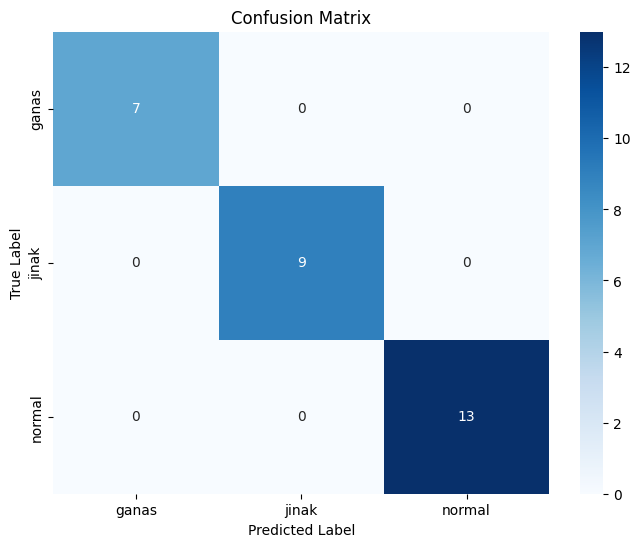

In [132]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define the class names
class_names = ['ganas', 'jinak', 'normal']

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
